#### 分为数据维度分析和机器学习两部分
#### 机器学习在下面哈

## 连接数据库


In [230]:
import sqlite3 #连接到 SQLite

db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as pyplot

借助 pandas 的 read_sql_query 函数执行 SQL 查询，将查询结果以 DataFrame 的形式返回

In [232]:
import pandas as pd

def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

## 订单量

说明一下，order_id下的订单状态不仅有delivered，还有其他的状态

In [233]:
# 前三列
view_table('orders',5).iloc[:,:3]

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


In [234]:
# 第三列之后的列
view_table('orders', 5).iloc[:, 3:]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [235]:
orders_per_day =  """
select
    date(order_purchase_timestamp)as day,
    count(*) as order_count
from orders
group by day
"""
df = pd.read_sql_query(orders_per_day,db_connection)
df.head(5)

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


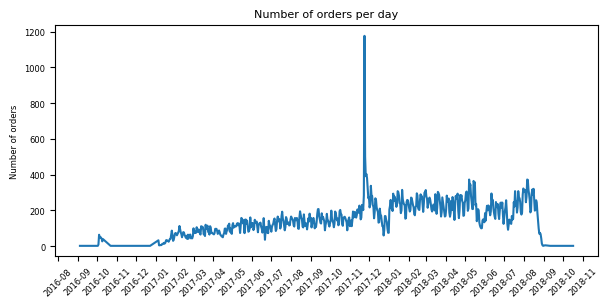

In [236]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 8

plt.figure(figsize=(7, 3))
plt.plot(pd.to_datetime(df['day']), df['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

根据图可以看到，2016的开头和2018的年末该订单数量极少，2017年12月订单量顶峰。我们假设猜测，是不是该公司的生命周期就在这段时间内？

查看每周的订单数量和星期几，时间点的关系 orders weekday hour

In [237]:
order_day_hour =  """
SELECT
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '0' THEN 'Sun'
        END AS day_of_week_name,        -- 周一为1 周日为7
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week_int,                                                                           
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hour
FROM orders
"""
pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Mon,1,10
1,Tue,2,20
2,Wed,3,8
3,Sat,6,19
4,Tue,2,21
...,...,...,...
99436,Thu,4,9
99437,Tue,2,12
99438,Sun,0,14
99439,Mon,1,21


查看每周每天中每个时间点的订单数量有多少，并且用heatmap热力图展示

In [238]:
count_orders_per_hour = ',\n    '.join(
    [
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' 
    for i in range(24)
]
)

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

SQL query 没有 CTE的话他就把迭代的那些都展示出来了

In [239]:
print(orders_per_day_of_the_week_and_hour[591:])

_of_week_name,
    COUNT(CASE WHEN hour = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hour = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hour = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hour = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hour = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hour = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hour = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hour = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hour = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hour = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hour = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hour = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hour = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hour = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hour = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hour = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hour = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hour = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hour = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN hour = 19 THEN 1

执行完查询后，我们只需要将 day_of_the_week_name 列设置为 dataframe 索引，即可得到构建热力图所需的矩阵

In [240]:
df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sun,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Mon,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tue,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wed,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thu,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Fri,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Sat,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


mean_orders = df.mean().mean()        --所有数据的均值哈

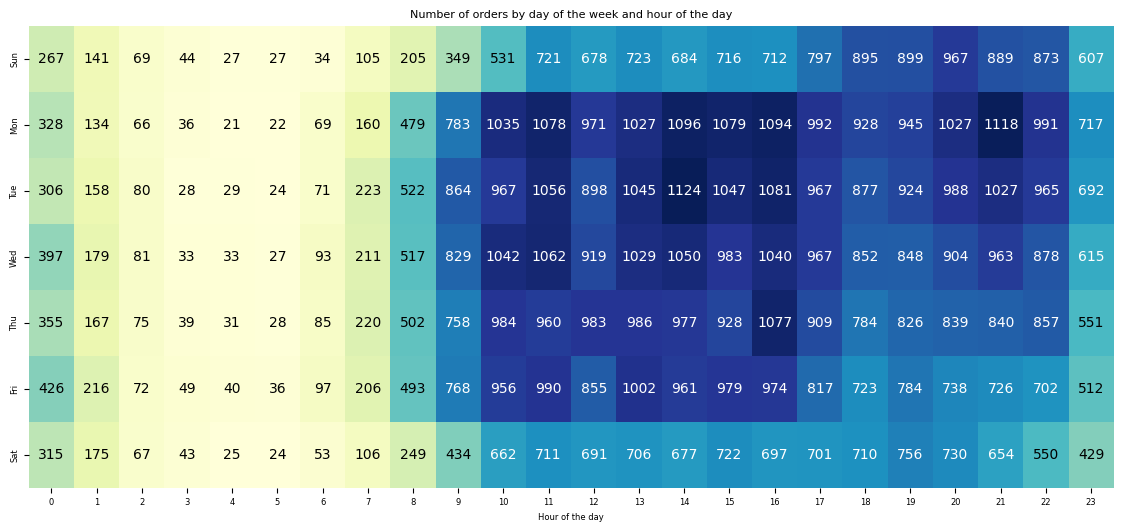

In [241]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='YlGnBu', cbar=False)
mean_orders = df.mean().mean()      
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")


plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

我们可以观察到,大多数订单是在工作日的上午10点到下午4点之间下达的,由于午餐时间,中午12点左右的销售额略有下降。从周日到周四,晚上9点左右,客户也会通过Olist订购。周六是订单最少的一天,尽管它仍然很繁忙。一天中最不繁忙的时间是凌晨3点到5点,尽管在此期间仍有少量订单。

现在我们已经研究了订单随时间的分布，我们可以看看地理分布。表 customers 包含每个客户的邮政编码前缀、城市和州。有两个客户 ID，customer_unique_id 是标识每个客户的 ID：

In [242]:
view_table('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


选出 Top10消费者订单量的城市

In [243]:
orders_per_city = """
SELECT 
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


In [244]:
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

In [245]:
top_cities

,customer_city,city,city_order_count
0,sao bernardo do campo,SAO BERNARDO DO CAMPO,938
1,guarulhos,GUARULHOS,1189
2,salvador,SALVADOR,1245
3,porto alegre,PORTO ALEGRE,1379
4,campinas,CAMPINAS,1444
5,curitiba,CURITIBA,1521
6,brasilia,BRASILIA,2131
7,belo horizonte,BELO HORIZONTE,2773
8,rio de janeiro,RIO DE JANEIRO,6882
9,sao paulo,SAO PAULO,15540


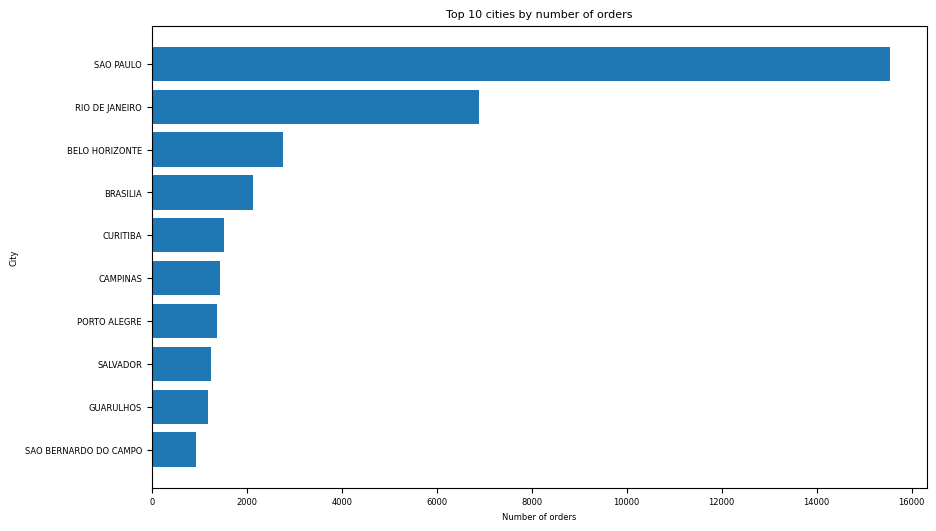

In [246]:
plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

可以看到 圣保罗和里约热内卢(SAO PAULO,RIO DE JANEIRO)的订单量远远大于其他城市

# 订单价格

订单的平均价值是多少？Olist 是否处理商品价值极低或者非常高的交易？查看order_items 表，该表包含各种 ID 以及订单商品的价格和运费。

In [247]:
view_table('order_items', 2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


考虑到产品价格和运费，平均订单价格是多少？


In [248]:
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


已知平均价格为160.58，即order价格围绕在160左右，而最大订单价格为13664.08，这意味着我们可能有一个右尾分布
我们接下来查看订单价格和运输成本之间的关系

根据下文分析可以得知，运价平均占订单价格的30.84% 不同订单的运价不同，占比不同
运价跟配送距离，产品体积大小有关，还有贵重物品的高价保单

In [249]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    sum(price) as  product_cost,
    sum(freight_value) as shipping_cost,
    round(sum(freight_value)/sum(price)*100,2) as shipping_cost_percentage
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost,shipping_cost_percentage
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,22.56
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,8.31
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.98
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,98.46
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,9.07
...,...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,14.47
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,10.44
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,16.97
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72,15.57


In [250]:
df['shipping_cost_percentage'].mean().round(2)

30.84

查看订单成本 
 -- 直方图对500元以内的订单价格的订单量
 -- 直方图对所有的运费的订单量

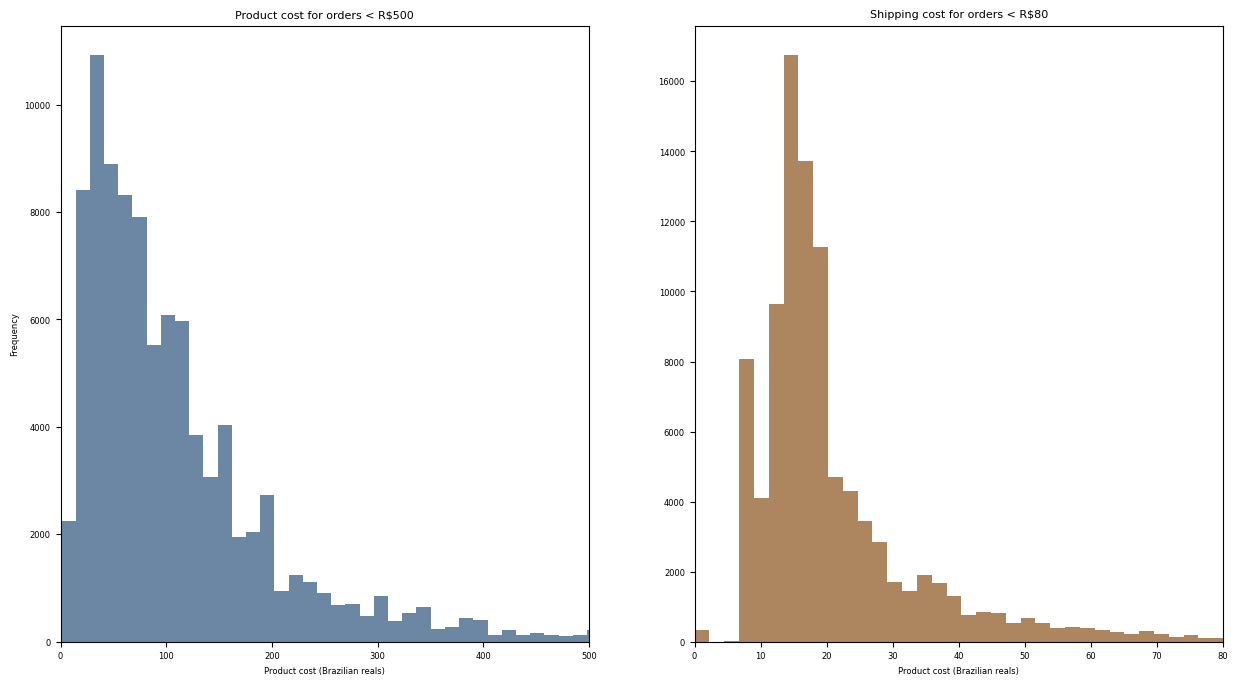

In [251]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])

plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

订单中的产品价格差异性很大，但大多数订单价格低于200以内，基本在100以内。运费也基本在7-20之间，很少低于这个价格。

# 产品类别
产品类别和重量的关系(物品重量决定物流价格)

In [252]:
view_table('products', 2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [253]:
view_table('products', 5).iloc[:, [0, 1, 5]]

,product_id,product_category_name,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0


有71种独特的产品类别。我们可以使用树形图来绘制使用区域的每个类别的相对销售情况。由于要可视化71个类别具有挑战性,因此我将选择前18个类别,并将其余类别分组为"其他类别"。首先,让我们获得每个类别的总销售额。我们还将使用包含英文类别名称的productcategoryname_translation表:

上面提到过订单状态会不同，所以这里要where选delivered 已送达的，去算他类别和物品重量的关系才准确！

In [254]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


使用前面的查询作为 CTE,我们将使用 rank 列来获取销售额排名前 18 的类别,并汇总其余类别。（因为分析所有的种类实在太多了）
UNION ALL 将两个子查询合并,确保"其他类别"将出现在表格的末尾

In [255]:
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
                   --取销售额排名18以内的
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
UNION ALL             --使用不去重是因为 本身数据就是分开的，去不去重都问题不大
SELECT
    'Other categories' AS category,          --其他的种类销售额aggregate聚合掉 
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


python里绘制treemap树状图的库 squarify
在此图中你可以清楚看到不同类别占比权重多少，方块大小决定

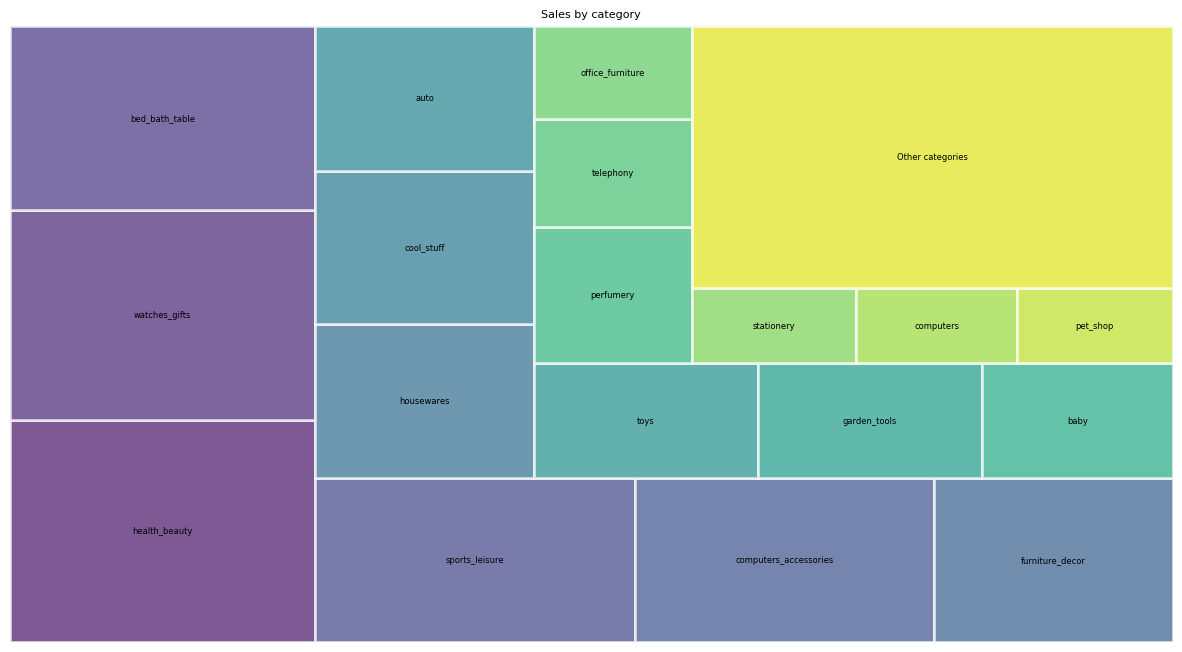

In [256]:
import squarify 

plt.figure(figsize=(15, 8))
plt.title('Sales by category')
color = sns.color_palette("viridis", len(df))
squarify.plot(sizes=df['sales'], label=df['category'],
                 alpha=0.7, color=color, edgecolor="white", linewidth=2)
plt.axis('off')
plt.show()

In [257]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')
top_18_categories

('health_beauty',
 'watches_gifts',
 'bed_bath_table',
 'sports_leisure',
 'computers_accessories',
 'furniture_decor',
 'housewares',
 'cool_stuff',
 'auto',
 'toys',
 'garden_tools',
 'baby',
 'perfumery',
 'telephony',
 'office_furniture',
 'stationery',
 'computers',
 'pet_shop')

我们使用行号排序来完成对每个类别中产品进行排序

In [258]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g asc) AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


我们可以在前面的查询字符串 'ordered_categories' 的基础上计算找出每个类别下订单重量的中位数相关信息，并返回按中位数排序的类别：
奇数选择 中间那行
偶数选择 中位数是中间两个数的平均值

In [259]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

,category
0,telephony
1,computers_accessories
2,watches_gifts
3,health_beauty
4,perfumery
5,baby
6,sports_leisure
7,toys
8,pet_shop
9,auto


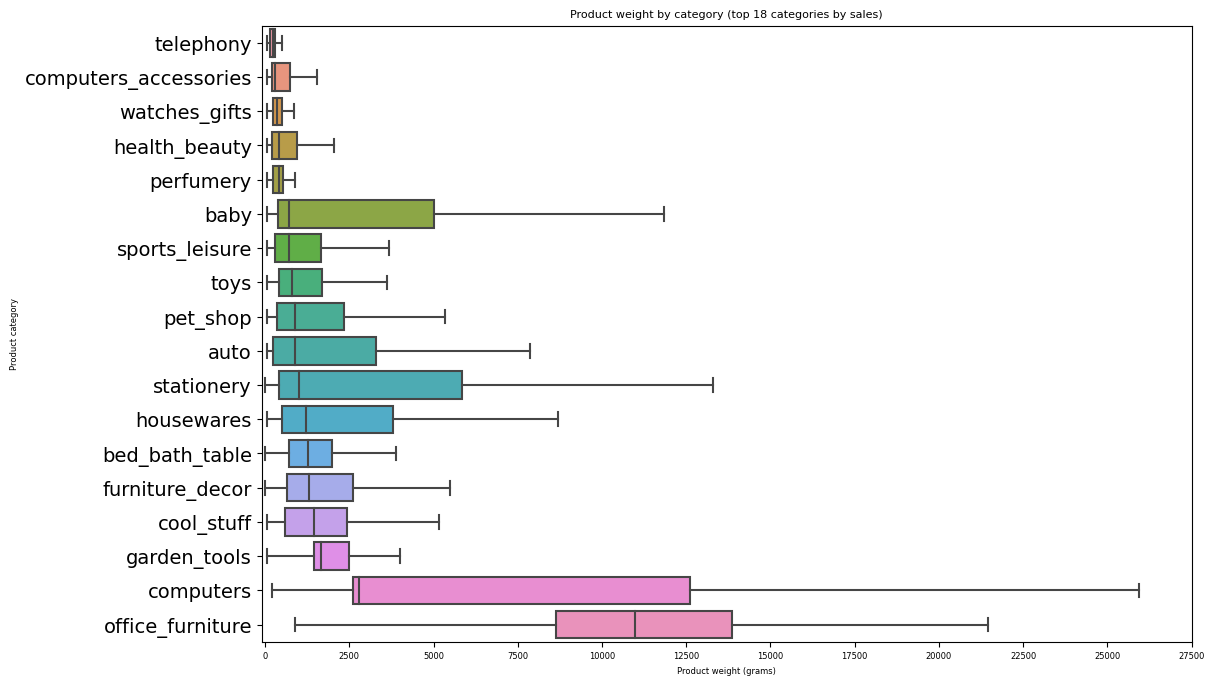

In [260]:
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, showfliers=False)  #showfliers 不会显示离群值
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

正如我们在图的顶部看到的，有五个类别，其物品大多低于 2 公斤：电话、电脑配件、watches_gifts、HealthBeauty。在底部，我们可以看到两个类别，计算机和办公文具，它们包含更重的产品。

<br>

# 销售额预测

对健康美容，自动化，玩具，电子产品，时尚鞋这5个类别做销售预测分析

In [261]:
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

要构建每个类别的月销售额折线图，我们需要一个销售额总和的矩阵，其中列是类别，行是月：

忽略2017-01-01前的订单，因为太少了哈

In [262]:
monthly_sales_selected_categories = f"""
SELECT 
    strftime('%Y-%m',order_purchase_timestamp) as year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df.head(2)

,health_beauty,auto,toys,electronics,fashion_shoes
year_month,,,,,
2017-01,12561.32,5218.53,4814.09,617.00,34.90
2017-02,22838.79,13162.40,9403.34,1218.85,107.05


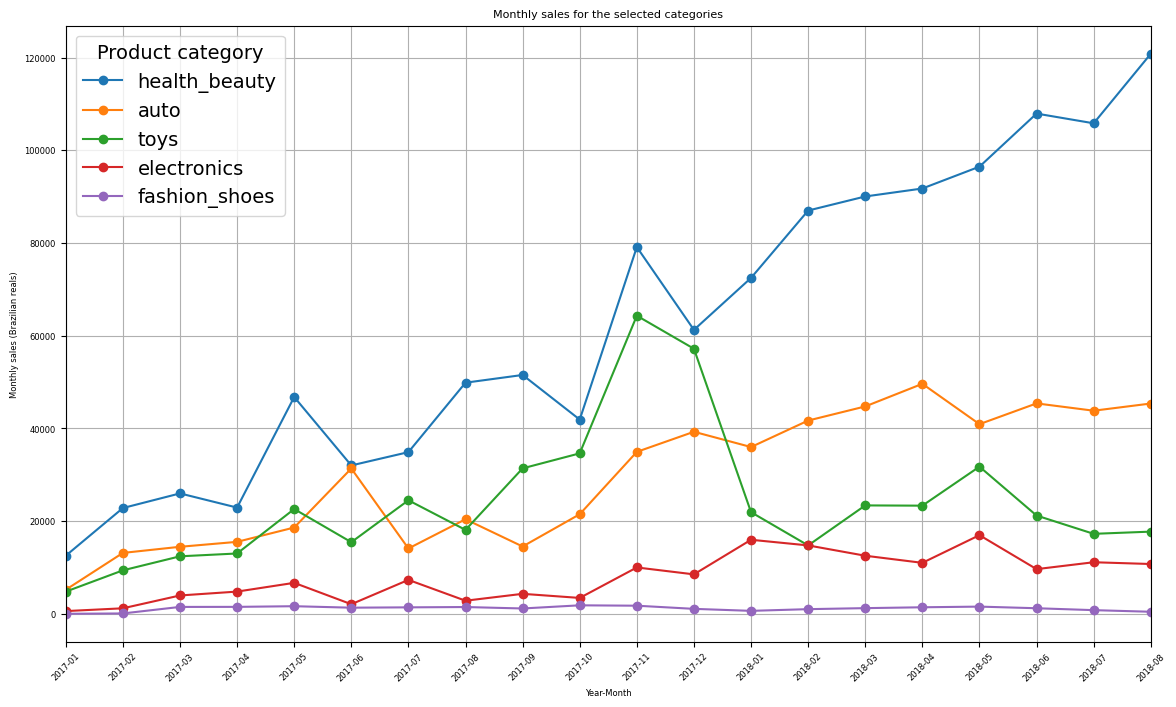

In [263]:
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

可以health_beauty 健康美容是卖的最好，紫色线条时尚鞋是最差的。

<br>

## Linear regression

我们要用线性回归来预测下一个季度/年。为此，首先我们需要获取计算每个类别的回归线所需的数据：days，自变量，应为数字格式，因此我们将计算自 2017-01-01 以来经过的天数;以及每天和类别的总销售额。

julianday SQlite里用来计算日期差， Mysql里是 datediff

In [264]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


我们可以将前面的查询用作 CTE，从中我们可以使用最小二乘法计算每个类别的回归线的斜率和截距。计算坡度的公式为：
$$ slope = \frac{n \sum(\text{day} \cdot \text{sales}) - (\sum \text{day})(\sum \text{sales})}{n \sum(\text{day}^2) - (\sum \text{day})^2} $$

$$ intercept = \frac{\sum \text{sales} - slope \cdot (\sum \text{day})}{n} $$

- n = count(*)
- xy = sum(day * sales)
- x * y  = sum(day)*sum(sales)
- n * x^2 = count(*) * sum(day * day)
- (X)^2 = sum(day)^2
- y = sum(sales)
- slope*sum(day)

In [265]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

,category,slope,intercept
0,auto,2.257831,319.055318
1,electronics,0.614535,105.302974
2,fashion_shoes,0.126815,89.637179
3,health_beauty,5.876734,305.451543
4,toys,0.563910,649.648518


根据每个类别的slope and intercept 做直线图

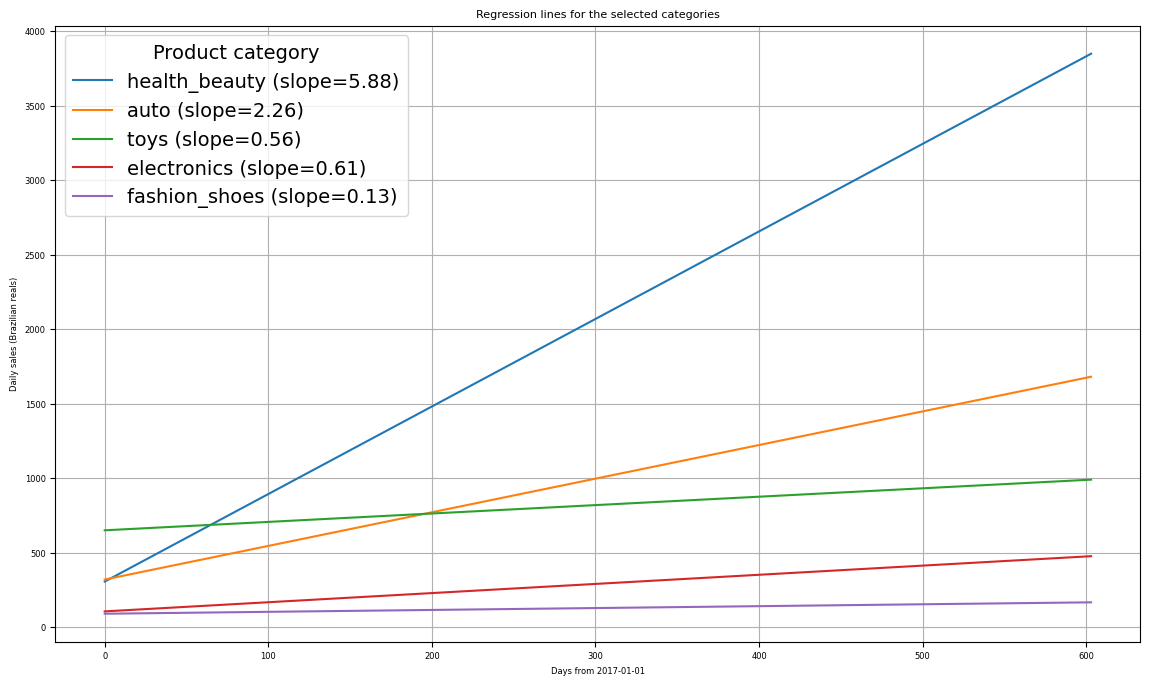

In [266]:
import numpy as np

plt.figure(figsize=(14, 8))
days = np.arange(0, 604)               #上面可知的最大的间隔天数
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]  # values把series变成numpy数组，索引取数
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})') 
    
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

如果假设每个类别的回归线中的趋势在接下来的几个月中将继续，那么可以使用它们来预测每日销售额。为了计算 2018 年 12 月每天的预测销售额，我将 2017 年 12 月至 2018 年 12 月的销售额增长量乘以 2017 年 12 月每天的销售额：
$$
sales_{day + 365} = \frac{intercept + slope \cdot (day + 365)}{intercept + slope \cdot day} \cdot sales_{day}
$$

使用每日预测来计算 5 天移动平均线，以消除由于每日销售额波动而导致的噪音：
因为噪音是随机的，在连续的 5 天中，随机的波动可能会在不同方向上出现，当我们计算这 5 天的平均值时，这些随机的正向和负向波动会相互抵消一部分

In [267]:
# 5天平均线 = 当天+前两天+后两天
# AVG(forecasted_sales) OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING) AS moving_avg_sales

In [268]:
#  365 = cast(julianday('2018-12-31') - julianday('2017-12-31') as integer)

In [269]:
# 筛选2018年12月的数据做折线图
# ‘ 365天 ’ between 上下年度11个月 and 上下年度12个月  = 2018年12月
# day + cast(julianday('2018-12-31') - julianday('2017-12-31') as integer) between cast(julianday('2018-12-31') - julianday('2017-12-31') as integer) - CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)

CAST(strftime('%d', date) AS INTEGER) AS december_2018_day 简化day的格式 变成数字的

In [270]:
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,  
    category,
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

,december_2018_day,category,moving_avg_sales
0,1,auto,2438.257278
1,2,auto,2957.096207
2,3,auto,2612.112277
3,4,auto,3034.655653
4,5,auto,2919.956942
...,...,...,...
126,27,toys,1247.841517
127,28,toys,857.343323
128,29,toys,585.209963
129,30,toys,621.773116


在下一个图中，可以看到每个类别在 2018 年 12 月的预测销售额：

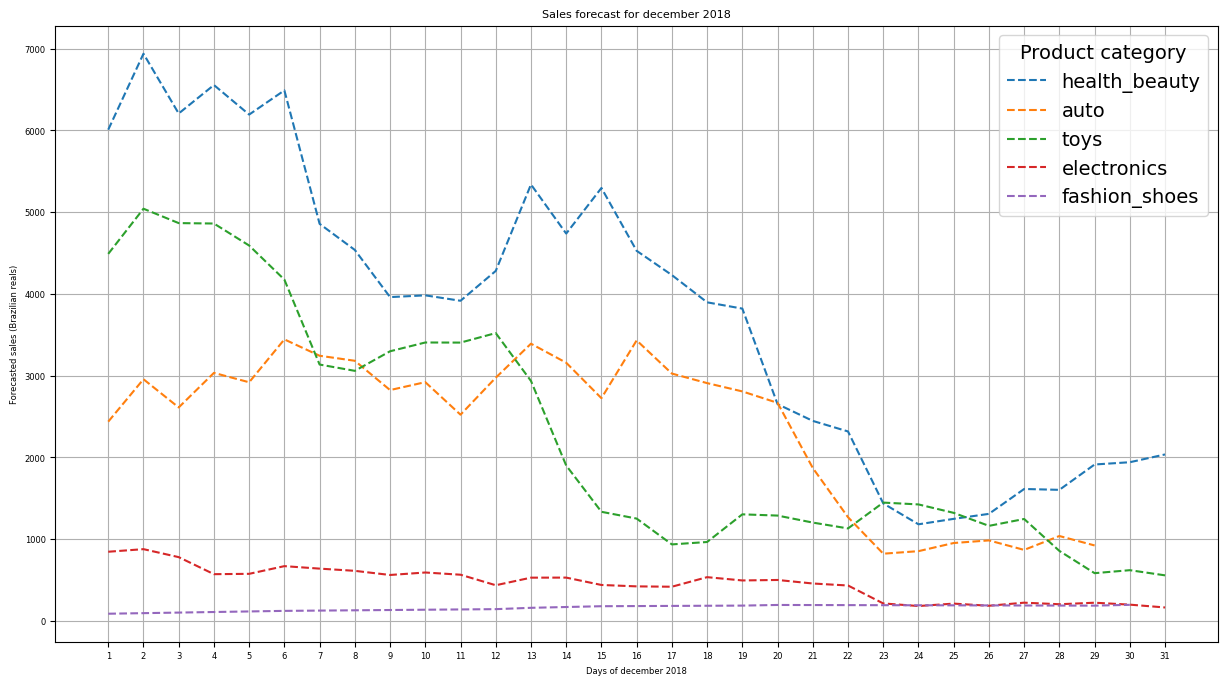

In [271]:
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
    
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

模型预测 health_beauty 将成为我们研究的五个类别中销量最高的类别，并且其销售额将缓慢下降，直到圣诞节。玩具 在前两周的销售额将保持强劲，但之后会急剧下降。auto 销售额在前 3 周保持稳定，但之后会下降。电子产品遵循类似的趋势，但fashion_shoes的销售额似乎与假日趋势无关，在月底略有增长。

##  订单配送


图表可看到，orders 表包含各种时间戳：
- order_purchase_timestamp：订单由客户下达
- order_approved_at：订单由 Olist 批准
- order_delivered_carrier_date：订单已交给运输公司
- order_delivered_customer_date：客户收到订单
- order_estimated_delivery_date：交货日期估计

每个时间戳都代表配送的一个阶段，所以！我们接下来要计算每个阶段配送的平均时间。

In [272]:
order_stage_times_top_10_citites = f"""
SELECT 
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df

,approved,delivered_to_carrier,delivered_to_customer,estimated_delivery
city,,,,
SALVADOR,0.498863,2.700868,16.160566,8.755085
PORTO ALEGRE,0.420697,2.809786,12.786769,11.091915
RIO DE JANEIRO,0.383342,2.979133,11.409813,12.504991
BRASILIA,0.432585,2.762064,9.805472,11.333709
BELO HORIZONTE,0.378608,2.848813,7.900486,11.901479
CURITIBA,0.453929,2.690824,7.316206,12.732135
CAMPINAS,0.420262,2.784653,6.611740,8.821432
SAO BERNARDO DO CAMPO,0.349693,2.702651,5.045101,9.799631
SAO PAULO,0.385928,2.726784,4.961921,10.027349


堆积条形图 Stacked Bar Chart  

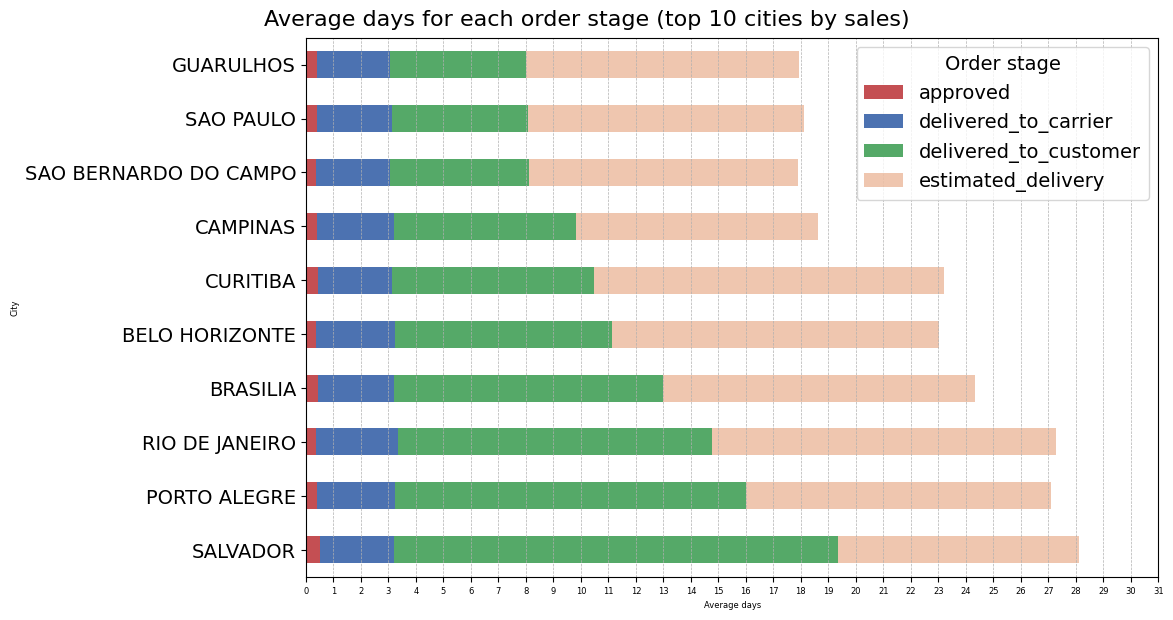

In [273]:
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=16, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())

ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()

从订单被批准到发货的周期不同城市之间都是相似的，大约 3 天。相比之下，订单送达买家所需的时间因城市而异：圣保罗、瓜鲁柳斯和圣贝尔纳多-杜坎波的平均配送时间相同，均为 5 天，而对于排名靠后的城市，如里约热内卢、阿雷格里港和萨尔瓦多，从快递运输时间平均需要两倍多。其次，平均预计交货日期比实际交货至少晚一周。

运输时间是否跟季节性有关？创建一个每日平均运输时间的折线图，选择 2017 年 6 月至 2018 年 6 月期间的订单

In [274]:
daily_avg_shipping_time = """
SELECT
    DATE(order_purchase_timestamp) AS purchase_date,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp))
        AS avg_delivery_time
FROM orders
WHERE order_purchase_timestamp >= '2017-06-01' AND order_purchase_timestamp <= '2018-06-30'
GROUP BY DATE(order_purchase_timestamp)
"""

df = pd.read_sql_query(daily_avg_shipping_time, db_connection)
df.head(5)

,purchase_date,avg_delivery_time
0,2017-06-01,11.238623
1,2017-06-02,12.079623
2,2017-06-03,14.255051
3,2017-06-04,12.064359
4,2017-06-05,11.101563


让我们绘制时间序列，其中一条红线显示年度平均运输时间

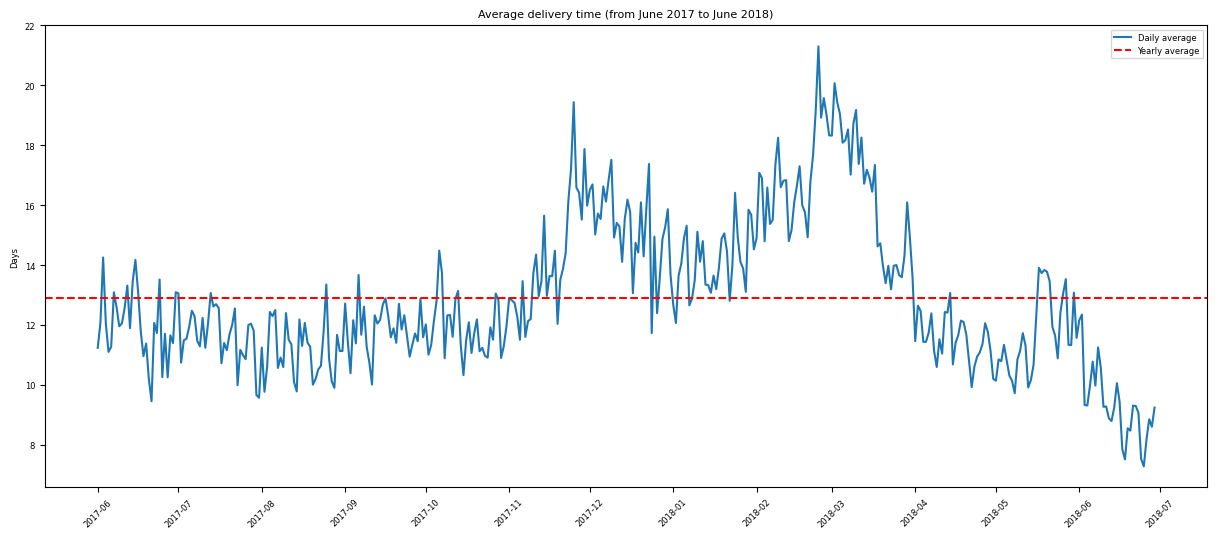

In [275]:
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(df['purchase_date']), df['avg_delivery_time'], label='Daily average')
plt.axhline(y=df['avg_delivery_time'].mean(), color='r', linestyle='--', label='Yearly average')
plt.ylabel('Days')
plt.title('Average delivery time (from June 2017 to June 2018)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.show()

上图可见，有两个时期的运输时间明显高于平均水平：2017 年 12 月和 2018 年 2 月至 3 月。12 月的延误可能是由于假期繁忙造成的，但 2 月至 3 月的延误可能是由于别的特殊情况。

# Order reviews

数据库还包括一个 order_reviews 表。用户可以对 1 到 5 的订单进行评分，并在订单上写下评论。

In [276]:
view_table('order_reviews', 2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13


In [277]:
view_table('order_reviews',5).iloc[:,[1,2,4]]

,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,None
1,a548910a1c6147796b98fdf73dbeba33,5,None
2,f9e4b658b201a9f2ecdecbb34bed034b,5,None
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...


查看1-5分的订单数量分布

In [278]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM order_reviews
GROUP BY review_score
"""
df = pd.read_sql_query(review_score_count, db_connection)
df

,review_score,count
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


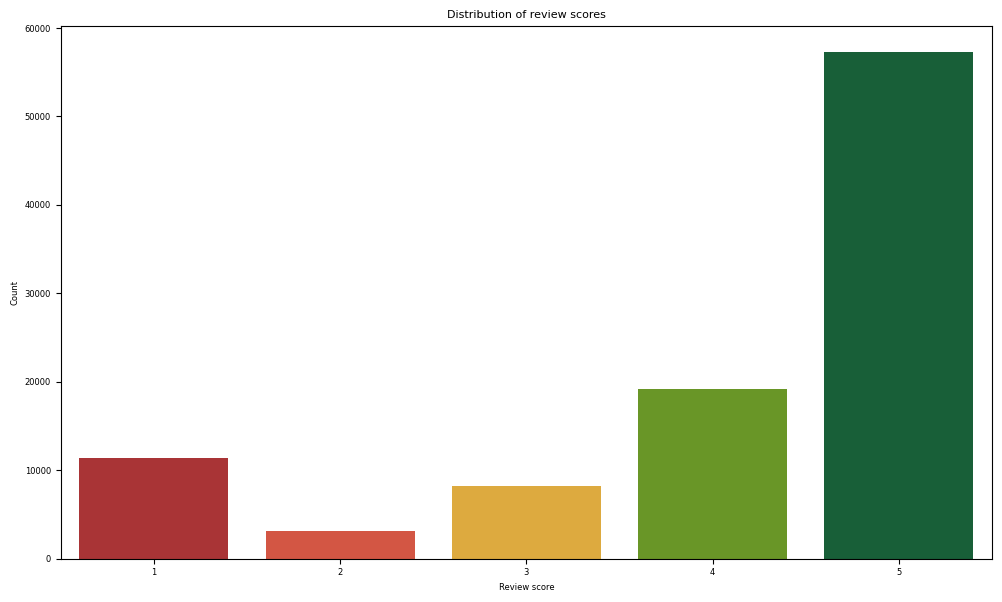

In [279]:
plt.figure(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']
sns.barplot(x='review_score', y='count', data=df, hue='review_score', palette=colors, dodge=False)
plt.title('Distribution of review scores')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()

上图可以看到，大多数评论评分都非常积极，但也有相当数量的客户不满意。原因是什么？我们需要创建一个分数为 1 或 2 的评论词云来看看原因。

GROUP_CONCAT 函数，用于将分组中的多个值连接成一个字符串

In [280]:
negative_comments = """
SELECT GROUP_CONCAT(review_comment_message, ' ') AS comments
FROM order_reviews
WHERE review_score IN (1,2)
"""

negative_comments_df = pd.read_sql(negative_comments, db_connection)['comments'][0]
negative_comments_df[:150]

'GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU Péssimo Não gostei ! Comprei gato por lebre Sempre compro pela Internet'

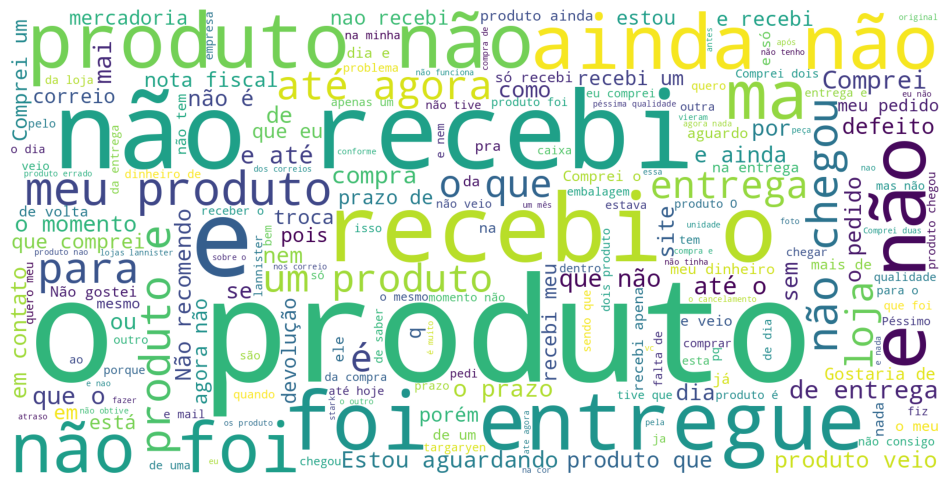

In [281]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(negative_comments_df)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

负面评论的主要原因与运输延误有关，对产品质量的不满意或其他订单错误似乎是次要的

# 客户细分

用RFM，根据三个指标对客户进行分组：
- Recency：最近1次消费时间间隔
- Frequency： 消费频率
- Monetary： 消费金额

之后，每个客户都会根据其 RFM 分数分配到一个类别，然后用气泡图bubble chart 可视化

In [282]:
# 根据 RFM 三个指标 单独的给他们 Ntile分组
# 最近 1 次的消费

#    SELECT customer_unique_id,
#           MAX(order_purchase_timestamp) AS last_purchase,
#           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
#    FROM orders
#        JOIN customers USING (customer_id)
#    WHERE order_status = 'delivered'
#    GROUP BY customer_unique_id

In [283]:
# 消费频率 
#   SELECT customer_unique_id,
#           COUNT(order_id) AS total_orders,
#           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
#    FROM orders
#        JOIN customers USING (customer_id)
#    WHERE order_status = 'delivered'
#    GROUP BY customer_unique_id

In [284]:
# 消费金额
#   SELECT customer_unique_id,
#           SUM(price) AS total_spent,
#           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
#    FROM orders
#        JOIN order_items USING (order_id)
#        JOIN customers USING (customer_id)
#    WHERE order_status = 'delivered'
 #   GROUP BY customer_unique_id

In [285]:
rfm_buckets = """
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "champions"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "can't lose them"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users" 
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Potential Loyalist"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About To Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
)

SELECT RFM_Bucket, 
       AVG(JULIANDAY('2019-01-01') - JULIANDAY(last_purchase)) AS avg_days_since_purchase, 
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""

df = pd.read_sql(rfm_buckets, db_connection)
df

,RFM_Bucket,avg_days_since_purchase,avg_sales_per_customer,customer_count
0,About To Sleep,343.171771,57.684959,7584
1,Hibernating,517.484757,182.845816,20288
2,Lost,520.013535,57.393210,15331
3,Loyal Customers,300.667800,237.881257,9315
4,Needs Attention,344.228852,145.904925,6510
5,Potential Loyalist,227.362969,130.374773,18114
6,Price Sensitive,168.826932,34.909351,2220
7,Promising,260.316604,35.085359,2245
8,Recent Users,168.575676,67.642129,5421
9,can't lose them,516.475080,350.886817,1723


In [286]:
# 上面计算间隔时间用了‘2019-01-01’
df['avg_days_since_purchase'].max()
df['avg_days_since_purchase'].min()

168.57567590799113

把平均最近一次消费作为横坐标，平均消费金额作为y坐标，气泡大小由客户数量决定

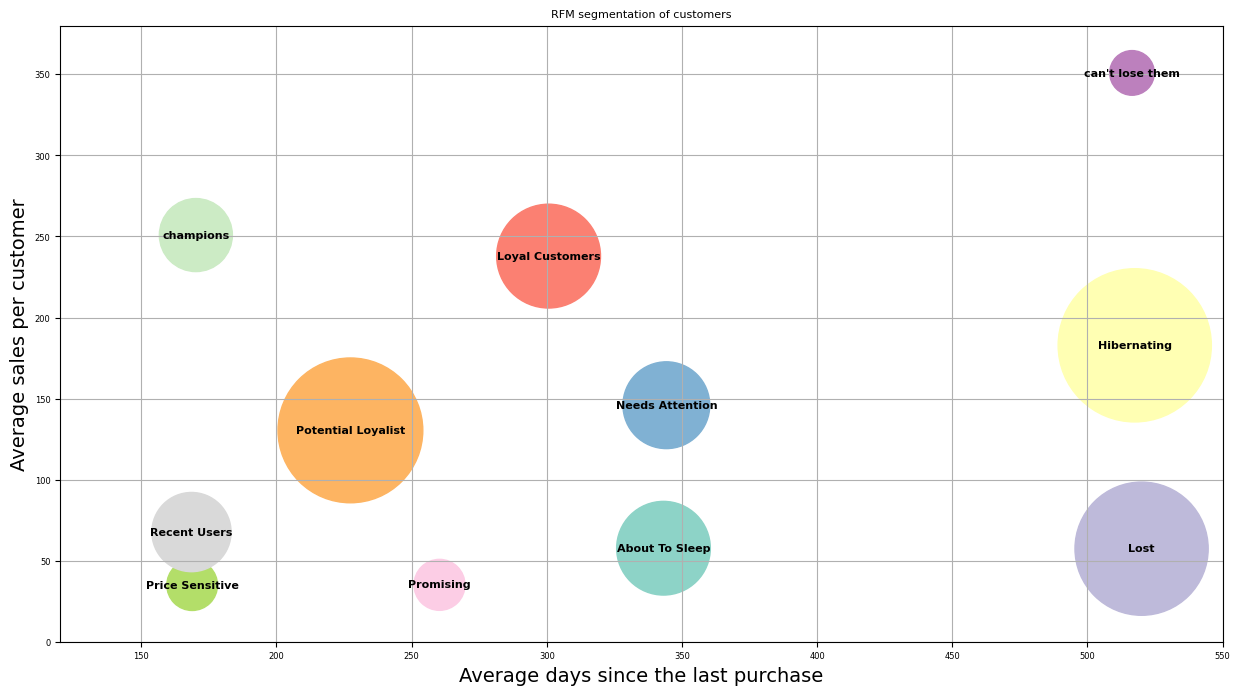

In [287]:
plt.figure(figsize=(15, 8))
scatter = plt.scatter(df['avg_days_since_purchase'], df['avg_sales_per_customer'],
    s=df['customer_count']*0.6, c=sns.color_palette('Set3', len(df)))
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM segmentation of customers')
plt.grid(True)

for i, text in enumerate(df['RFM_Bucket']):
    plt.annotate(text, (df['avg_days_since_purchase'][i], df['avg_sales_per_customer'][i]), 
        ha='center', va='center',fontsize=8, color='black', fontweight='bold')

plt.xlim(120, 550)
plt.ylim(0, 380)
plt.show()

上图向我们展示了每个客户细分在新近度和销售额方面的位置。例如，右上角的“Champions”细分销售额较高且最近购买过，而相反侧的“Lost”细分的销售额较低且最近没有购买。

构建一个一次性客户与回头客比例的图，以更深入地了解通过 Olist 购买的人的忠诚度

In [288]:
A="""
SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
"""
df= pd.read_sql_query(A, db_connection)
df

,order_count
0,1
1,1
2,1
3,1
4,1
...,...
96091,1
96092,1
96093,1
96094,1


 用 100.0 确保 浮点数计算，不会有整数除法问题 记得用在前面！

In [289]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
)
SELECT
    CASE WHEN order_count > 1 THEN 'repeat' ELSE 'one-time' END AS order_type,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM CustomerOrders), 1) AS proportion
FROM CustomerOrders
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

,order_type,proportion
0,one-time,96.9
1,repeat,3.1


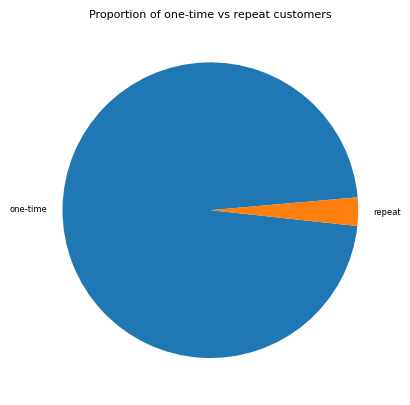

In [290]:
fig, ax = plt.subplots()
ax.pie(df['proportion'], labels=df['order_type'], startangle=5)
ax.set_title('Proportion of one-time vs repeat customers')
fig.set_facecolor('white') #背景设置为白色
plt.show()

上图所知，大多数客户都是回头客

# Customer lifetime value

客户生命周期价值 （CLV） 是商业中的一个重要指标，用于衡量与客户未来关系的预测价值。让我们计算数据集中客户的 CLV。为此，我们将引入一个新表 order_payments，其中包含已付款和使用的付款方式：

In [291]:
view_table('order_payments', 5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


- PF：购买频率            订单次数
- AOV：平均订单价值        总支付/总订单
- ACV：平均客户价值        
- ACL：客户平均生命周期    每个客户首次购买和最后一次购买的时间记录
- CLV = ACV*ACL
- CLV = PF * AOV * ACL

In [292]:
clv = """
WITH CustomerData AS (
    SELECT
        customer_unique_id,
        customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT orders.order_id) AS order_count,
        SUM(payment_value) AS total_payment,
        JULIANDAY(MIN(order_purchase_timestamp)) AS first_order_day,
        JULIANDAY(MAX(order_purchase_timestamp)) AS last_order_day
    FROM customers
        JOIN orders USING (customer_id)
        JOIN order_payments USING (order_id)
    GROUP BY customer_unique_id
)
SELECT
    customer_unique_id,
    zip_code_prefix,
    order_count AS PF,
    total_payment / order_count AS AOV,
    CASE
        WHEN (last_order_day - first_order_day) < 7 THEN
            1
        ELSE
            (last_order_day - first_order_day) / 7
        END AS ACL
FROM CustomerData
"""

clv1 = pd.read_sql(clv, db_connection)
clv1.head(2)

,customer_unique_id,zip_code_prefix,PF,AOV,ACL
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,1,141.90,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,1,27.19,1.0


In [293]:
greater_than = clv1[clv1['ACL'] != 1]
greater_than.head(2)

,customer_unique_id,zip_code_prefix,PF,AOV,ACL
33,00172711b30d52eea8b313a7f2cced02,45200,2,122.070,2.338323
106,004288347e5e88a27ded2bb23747066c,26220,2,177.185,24.389271


我们想要做一张巴西各个地区的客户CLV的分布地图

In [294]:
view_table('geolocation', 5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [295]:
avg_clv_per_zip_prefix = f"""
WITH CLV AS (
    {clv}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
    JOIN geolocation ON CLV.zip_code_prefix = geolocation.geolocation_zip_code_prefix
GROUP BY zip_code_prefix
"""

df = pd.read_sql(avg_clv_per_zip_prefix, db_connection)
df.head(5)

,zip_prefix,avg_CLV,customer_count,latitude,longitude
0,1003,98.970000,17,-23.549032,-46.635313
1,1004,99.055000,44,-23.550116,-46.635122
2,1005,1082.762826,125,-23.549819,-46.635606
3,1006,434.025000,18,-23.550524,-46.636694
4,1007,126.387500,104,-23.550393,-46.637302


- 利用python里的 folium' 库创建交互式地图
- 对于每个邮政编码前缀，在地图中绘制一个圆圈，使用 opacity 表示 CLV，使用 size 表示客户数量

row 替代 zip_prefix 作为迭代变量哈

In [296]:
map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=0.1 * np.sqrt(row['customer_count']),
        color=None,
        fill_color='#85001d',
        fill_opacity=0.1 + 0.1 * np.sqrt(row['avg_CLV'] / df['avg_CLV'].max()),
        popup=(
            f"<b>Zip Code Prefix:</b> {int(row['zip_prefix'])}<br>"
            f"<b>Average CLV:</b> {int(row['avg_CLV'])}<br>"
            f"<b>Customers:</b> {int(row['customer_count'])}"
        )
    ).add_to(map)

map.save('map.html')

从地图中可以看出，Olist 卖家的大部分客户价值都集中在巴西东南部人口最多的地区：圣保罗州，以及里约热内卢和贝洛奥里藏特等城市周围。

# Product 同类

获得出现在 5 个以上订单中的产品列表

In [297]:
min_orders = 5

most_ordered_products = f"""
SELECT
    products.product_id,
    product_category_name_english AS category,
    COUNT(order_id) AS orders_count
FROM order_items
    JOIN products USING (product_id)
    JOIN product_category_name_translation AS tr
        ON products.product_category_name = tr.product_category_name
GROUP BY products.product_id
    HAVING COUNT(order_id) > {min_orders}
"""

most_ordered_products_df = pd.read_sql(most_ordered_products, db_connection)
most_ordered_products_df.head(5)

,product_id,category,orders_count
0,001795ec6f1b187d37335e1c4704762e,consoles_games,9
1,001b72dfd63e9833e8c02742adf472e3,furniture_decor,14
2,00210e41887c2a8ef9f791ebc780cc36,health_beauty,7
3,002159fe700ed3521f46cfcf6e941c76,fashion_shoes,8
4,00250175f79f584c14ab5cecd80553cd,housewares,11


需要获取有关产品之间关系的信,下面计算每对产品出现的订单数量，对同一订单中的产品组合使用自联接，并按产品对它们进行分组
-  a.product_id < b.product_id  避免重复计算产品对哈！


In [298]:
most_ordered_product_ids = tuple(most_ordered_products_df['product_id'])

products_often_ordered_together = f"""
SELECT
    a.product_id AS product_id1,
    b.product_id AS product_id2,
    COUNT(DISTINCT a.order_id) AS common_orders_count
FROM order_items AS a
    JOIN order_items AS b
        ON a.order_id = b.order_id  
        AND a.product_id < b.product_id 
WHERE
    a.product_id IN {most_ordered_product_ids} AND
    b.product_id IN {most_ordered_product_ids}
GROUP BY
    a.product_id,
    b.product_id
    HAVING COUNT(DISTINCT a.order_id) > {min_orders}
"""

products_often_ordered_together_df = pd.read_sql(products_often_ordered_together, db_connection)
products_often_ordered_together_df.head(5)

,product_id1,product_id2,common_orders_count
0,060cb19345d90064d1015407193c233d,98d61056e0568ba048e5d78038790e77,6
1,0bcc3eeca39e1064258aa1e932269894,422879e10f46682990de24d770e7f83d,6
2,0d85c435fd60b277ffb9e9b0f88f927a,ee57070aa3b24a06fdd0e02efd2d757d,6
3,18486698933fbb64af6c0a255f7dd64c,dbb67791e405873b259e4656bf971246,7
4,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29


构建经常一起购买的产品图谱

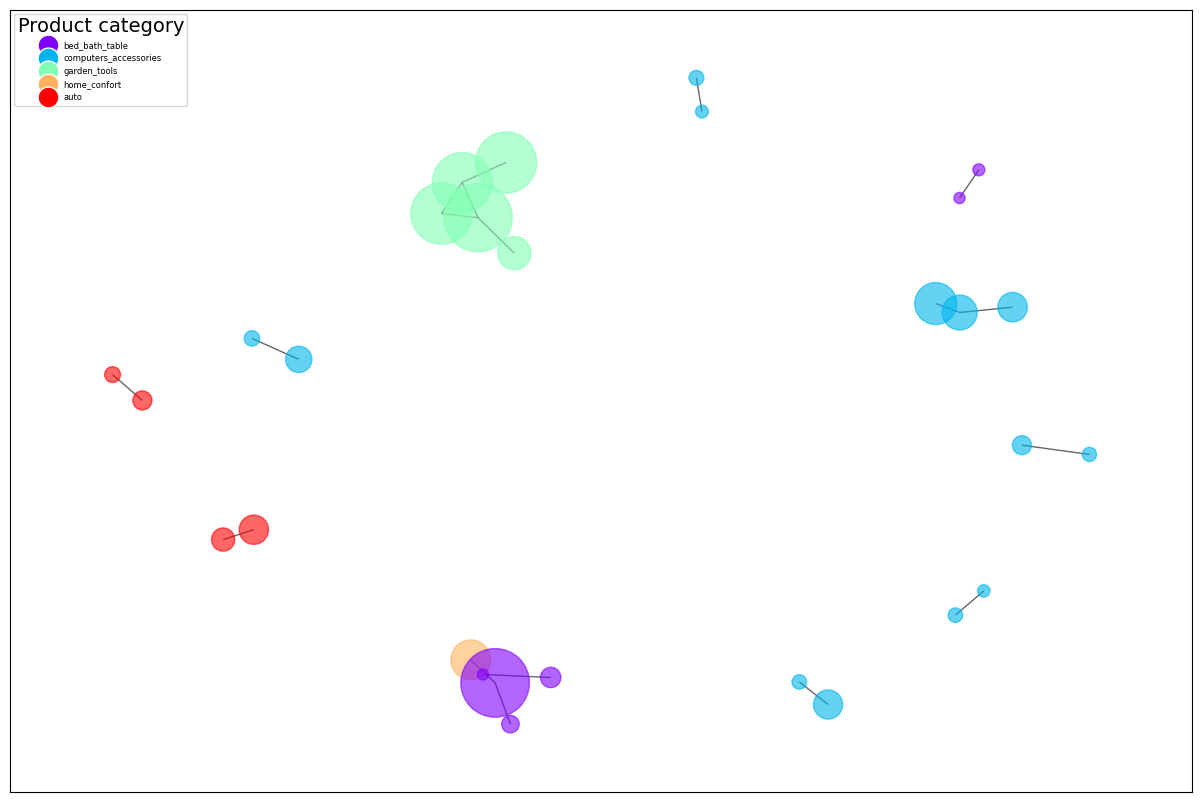

In [299]:
import networkx as nx

G = nx.Graph()
# Add nodes to the graph
for _, product in most_ordered_products_df.iterrows():
    G.add_node(product['product_id'], category=product['category'], orders_count=product['orders_count'])
# Add edges to the graph

for _, pair in products_often_ordered_together_df.iterrows():
    G.add_edge(pair['product_id1'], pair['product_id2'], weight=pair['common_orders_count'])
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# Assign colors to categories
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))

# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=50)
node_sizes = [G.nodes[n]['orders_count'] * 5 for n in G.nodes]
node_colors = [category_colors[G.nodes[n]['category']] for n in G.nodes]
nx.draw_networkx(G, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]

plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.show()

在图表中，每个圆圈代表一种产品，其颜色表示它所属的产品类别。两个产品之间的线条表示它们通常作为同一订单的一部分一起购买
- 圆圈的大小表示产品重要性，即整个数据集中有多少订单包含该产品。
- 园艺工具类别中有 5 种产品经常一起购买。还有一种来自床、浴室、桌子类别的产品，通常与 Home confort类别的另一种产品一起购买。
- 汽车和计算机配件类别中的一些产品也经常与同一类别的其他商品一起购买

# Sellers



In [300]:
view_table('sellers', 5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [301]:
sellers_num = '''
select count(seller_id) as num
from sellers
'''
df = pd.read_sql_query(sellers_num,db_connection)
df

,num
0,3095


问题
- 大多数卖家是小型、销售额较少，还是销售额较高的大型公司？
- 不同卖家的评论分数有什么区别？
- 试一下scatter chart

In [302]:
seller_review_scores_and_sales = '''
SELECT 
    a.seller_id,
    a.avg_review_score,
    a.total_sales,
    a.num_orders,
    row_number() over (order by a.num_orders desc) as rk
FROM (
    SELECT
        sellers.seller_id,
        AVG(order_reviews.review_score) AS avg_review_score,
        SUM(order_items.price) AS total_sales,
        COUNT(orders.order_id) AS num_orders
    FROM
        sellers
        LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
        LEFT JOIN orders ON order_items.order_id = orders.order_id
        LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    GROUP BY
        sellers.seller_id
    HAVING
        COUNT(orders.order_id) > 10
) AS a
ORDER BY 
    a.num_orders desc
'''
df = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df

,seller_id,avg_review_score,total_sales,num_orders,rk
0,6560211a19b47992c3666cc44a7e94c0,3.909406,123585.82,2039,1
1,4a3ca9315b744ce9f8e9374361493884,3.803931,202999.12,2009,2
2,1f50f920176fa81dab994f9023523100,3.982402,107431.41,1940,3
3,cc419e0650a3c5ba77189a1882b7556a,4.069575,106555.98,1819,4
4,da8622b14eb17ae2831f4ac5b9dab84a,4.071429,162723.37,1574,5
...,...,...,...,...,...
1310,f12d3c2a14729ae461b920c11fe20fdc,4.272727,364.45,11,1311
1311,fa74b2f3287d296e9fbd2cc80f2d1cf1,2.363636,2459.89,11,1312
1312,fce62094ffe6a4009188ec44e681dfdd,3.181818,2969.70,11,1313
1313,fe701d88b67eaca109dffd464d1be9f9,4.000000,1548.90,11,1314


In [303]:
df['total_sales'].mode()

0    2076.20
1    2575.90
2    9731.85
Name: total_sales, dtype: float64

散点图里，每个点都是一个卖家
- y 轴表示其平均订单评论分
- x 轴显示总销售额 因为大多数卖家的销售额非常低(上面mode)  销售额 对数刻度显示哈分布更均匀
- color 和 size 来表示订单数量

-因为做散点图，我剔除了10以下的订单，所以最小值是11
-但是下面分桶的时候要原来所有订单的哈 不要混淆

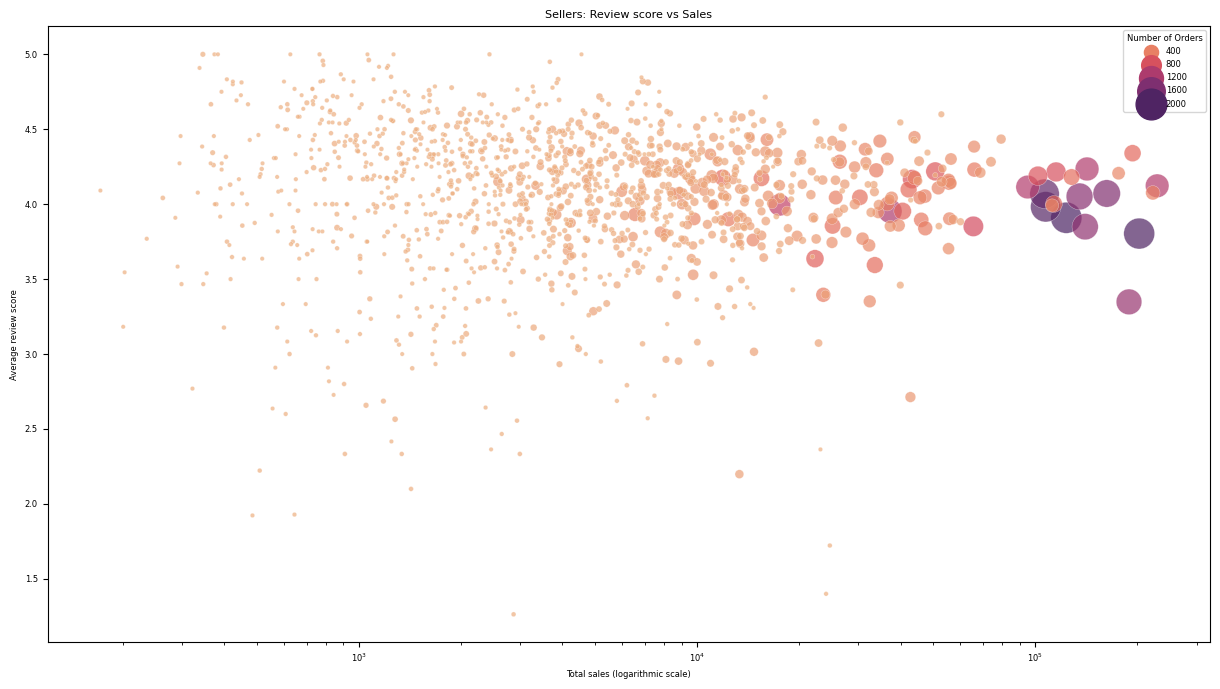

In [304]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500), 
                hue='num_orders', palette='flare', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales (logarithmic scale)')
plt.ylabel('Average review score')
plt.title('Sellers: Review score vs Sales')
plt.legend(title='Number of Orders')
plt.show()

上图可知，Olist 的大多数卖家都很小，大型卖家的平均订单评论分数差异较小，大多数卖家都在 3.5 到 4.5 之间
但在绘图右侧的大型卖家组中，有一个卖家的分数明显低于其同行。其次，有些卖家的总销售额相同，但订单数量明显不同，意味着部分卖家的客单价较高

In [305]:
seller_review_scores_and_sales = '''
SELECT 
    a.seller_id,
    a.avg_review_score,
    a.total_sales,
    a.num_orders,
    row_number() over (order by a.num_orders desc) as rk
FROM (
    SELECT
        sellers.seller_id,
        AVG(order_reviews.review_score) AS avg_review_score,
        SUM(order_items.price) AS total_sales,
        COUNT(orders.order_id) AS num_orders
    FROM
        sellers
        LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
        LEFT JOIN orders ON order_items.order_id = orders.order_id
        LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    GROUP BY
        sellers.seller_id
    ) AS a
ORDER BY 
    a.num_orders desc
'''
df1 = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df1.head(2)

,seller_id,avg_review_score,total_sales,num_orders,rk
0,6560211a19b47992c3666cc44a7e94c0,3.909406,123585.82,2039,1
1,4a3ca9315b744ce9f8e9374361493884,3.803931,202999.12,2009,2


In [306]:
statistics = {
    '平均值': df['num_orders'].mean().round(2),
    '最大值': df['num_orders'].max().round(2),
    '最小值': df['num_orders'].min().round(2),
    '中位数': df['num_orders'].median().round(2)
}
nums = pd.DataFrame.from_dict(statistics,orient='index')
nums

,0
平均值,81.19
最大值,2039.00
最小值,11.00
中位数,31.00


可视化了解按订单大小划分的卖家分布
根据订单数量将卖家分为 4 组
- Group 1: Sellers with 1-9 orders.
- Group 2: Sellers with 10-99 orders.
- Group 3: Sellers with 100-199 orders.
- Group 4: Sellers with 1000 or more orders.

In [307]:
bucketed_sellers = """
SELECT
    seller_id,
    CASE 
        WHEN COUNT(order_id) BETWEEN 1 AND 9 THEN '1-9 orders'
        WHEN COUNT(order_id) BETWEEN 10 AND 99 THEN '10-99 orders'
        WHEN COUNT(order_id) BETWEEN 100 AND 999 THEN '100-999 orders'
        ELSE '1000+ orders'
    END AS bucket
FROM order_items
GROUP BY seller_id
"""

pd.read_sql_query(bucketed_sellers, db_connection).head(5)

,seller_id,bucket
0,0015a82c2db000af6aaaf3ae2ecb0532,1-9 orders
1,001cca7ae9ae17fb1caed9dfb1094831,100-999 orders
2,001e6ad469a905060d959994f1b41e4f,1-9 orders
3,002100f778ceb8431b7a1020ff7ab48f,10-99 orders
4,003554e2dce176b5555353e4f3555ac8,1-9 orders


In [308]:
sellers_per_bucket = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT 
    bucket,
    COUNT(seller_id) AS seller_count
FROM BucketedSellers
GROUP BY bucket
"""

seller_buckets = pd.read_sql_query(sellers_per_bucket, db_connection)
seller_buckets

,bucket,seller_count
0,1-9 orders,1714
1,10-99 orders,1142
2,100-999 orders,226
3,1000+ orders,13


Let's visualize the dataframe:

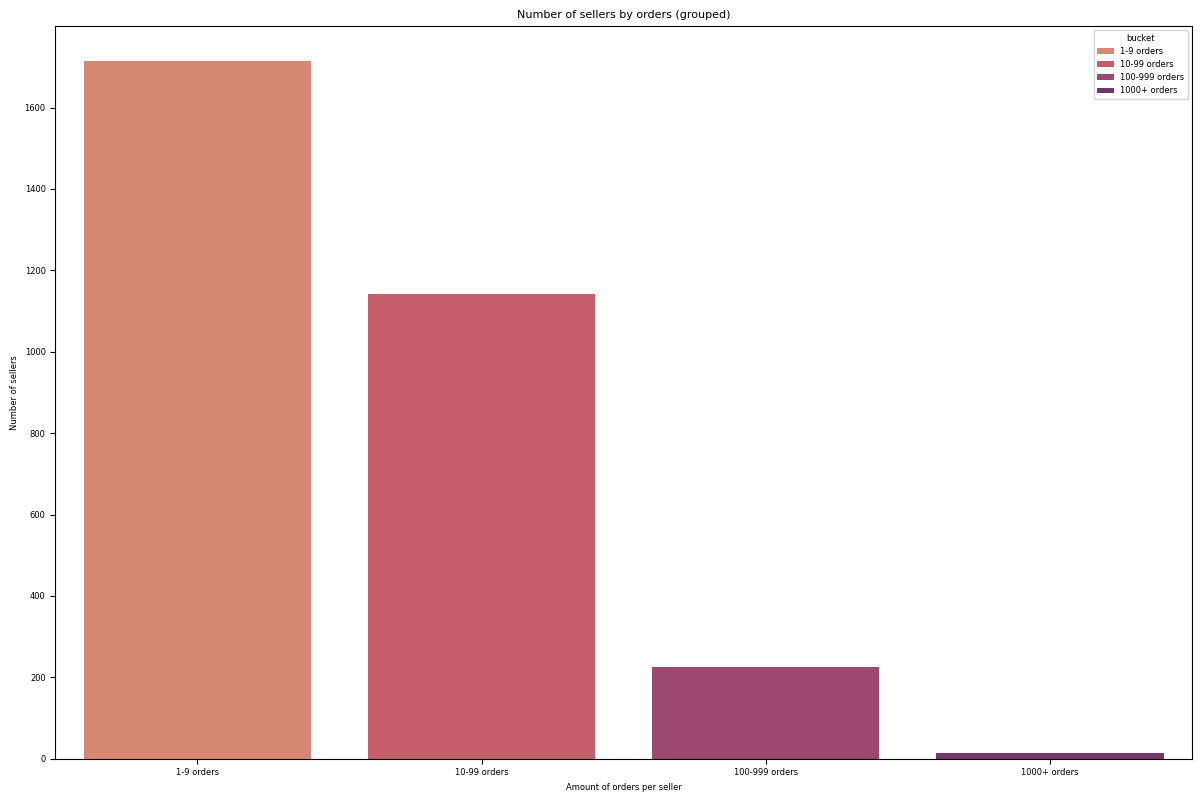

In [309]:
plt.figure(figsize=(12, 8))
sns.barplot(x='bucket', y='seller_count', data=seller_buckets, hue='bucket', palette='flare', dodge=False)
plt.title('Number of sellers by orders (grouped)')
plt.xlabel('Amount of orders per seller')
plt.ylabel('Number of sellers')
plt.tight_layout()
plt.show()

我们可以得知大多数商家都是小规模，1-9订单数的商家有1714

#### 那么较大的卖家的配送时间是否较短？

In [310]:
seller_shipping_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)
        AS delivery_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
group by bucket
"""

df = pd.read_sql_query(seller_shipping_times, db_connection)
df.head(5)

,bucket,seller_id,delivery_time
0,1-9 orders,0015a82c2db000af6aaaf3ae2ecb0532,9.353831
1,10-99 orders,002100f778ceb8431b7a1020ff7ab48f,17.243553
2,100-999 orders,001cca7ae9ae17fb1caed9dfb1094831,8.393542
3,1000+ orders,1025f0e2d44d7041d6cf58b6550e0bfa,5.094375


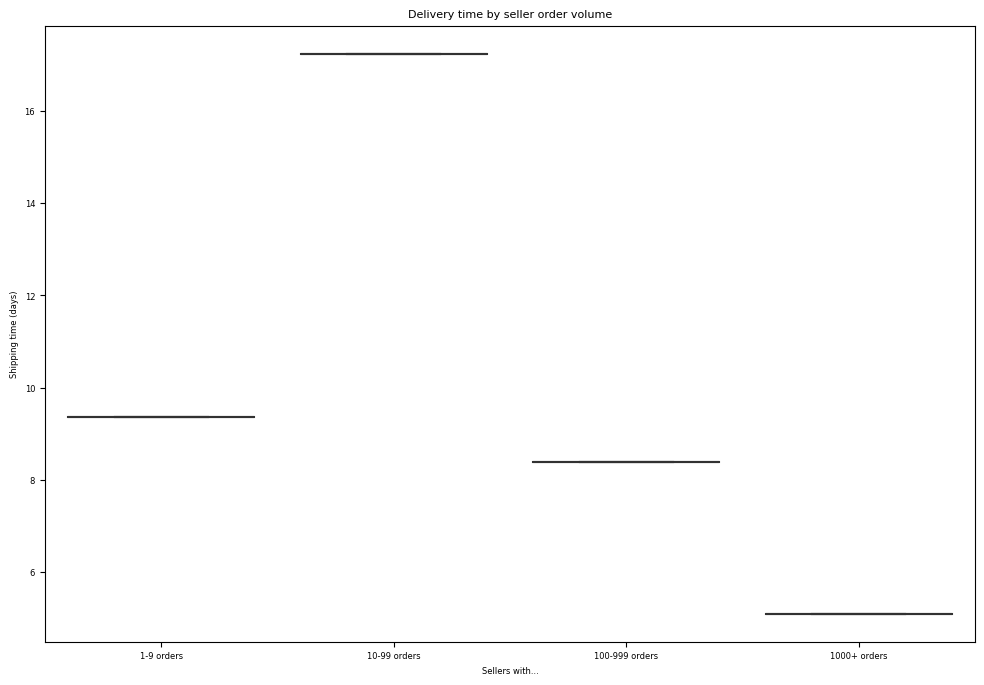

In [311]:
plt.figure(figsize=(12, 8))
palette = sns.color_palette('flare', len(seller_buckets['bucket']))
sns.boxplot(x='bucket', y='delivery_time', data=df, order=seller_buckets['bucket'], showfliers=False,
          hue='bucket', palette=palette[1:]+palette[:1], dodge=False)

plt.title('Delivery time by seller order volume')
plt.xlabel('Sellers with...')
plt.ylabel('Shipping time (days)')
plt.legend().remove() 
plt.show()

In [312]:
seller_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at) AS approved_delivery_time,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date) AS customer_time,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp) AS order_deliveried_time,
    JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date) AS extra_time,
    JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_purchase_timestamp) AS all_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
group by bucket
"""

df = pd.read_sql_query(seller_times, db_connection)
df.head(5)

,bucket,seller_id,approved_delivery_time,customer_time,order_deliveried_time,extra_time,all_time
0,1-9 orders,0015a82c2db000af6aaaf3ae2ecb0532,1.606030,7.095185,9.353831,12.301331,21.655162
1,10-99 orders,002100f778ceb8431b7a1020ff7ab48f,3.670359,11.826435,17.243553,8.329363,25.572917
2,100-999 orders,001cca7ae9ae17fb1caed9dfb1094831,1.455671,6.892187,8.393542,13.589387,21.982928
3,1000+ orders,1025f0e2d44d7041d6cf58b6550e0bfa,0.763125,4.319722,5.094375,12.080972,17.175347


分析可知
1. order_delivered_customer_date 订单交付日期才是最真实的日期，预估的日期要比它多
2. 10-99的小型商家批准时间和送达时间都是最长的
3. 1000+的大型商家他的批准时间最短，配送时间平均为4.32
4. 100-99的中型商家的预估和实际时间差最长

# 潜在客户

leads_qualified，其中包含在 Olist 网站上填写联系请求表的卖家列表，由销售团队过滤（因此成为“合格”）：

In [313]:
view_table('leads_qualified', 5)

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


第二个表 leads_closed 包含有关哪些以前的卖家加入了 Olist 的平台的信息

In [314]:
view_table('leads_closed', 5).iloc[:, [0,3,4,5]]

,mql_id,sr_id,won_date,business_segment
0,5420aad7fec3549a85876ba1c529bd84,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet
1,a555fb36b9368110ede0f043dfc3b9a0,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories
2,327174d3648a2d047e8940d7d15204ca,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances
3,f5fee8f7da74f4887f5bcae2bafb6dd6,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink
4,ffe640179b554e295c167a2f6be528e0,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances


In [315]:
count_null = """
select count(*) as null_count
from leads_qualified
where origin is null
"""

test = pd.read_sql_query(count_null, db_connection)
test

,null_count
0,60



多少人注册了Olist,多少人审核为合格
- 需要把NULL的数据处理掉 coalesce 替代掉，成为unknown

In [316]:
lead_conversion = """
SELECT 
    COALESCE(origin, 'unknown') AS origin,
    COUNT(DISTINCT leads_qualified.mql_id) AS qualified_leads,
    COUNT(DISTINCT leads_closed.mql_id) AS closed_leads,
    COUNT(DISTINCT leads_closed.mql_id) * 100.0 / COUNT(DISTINCT leads_qualified.mql_id)
        AS conversion_rate
FROM leads_qualified
    LEFT JOIN leads_closed USING (mql_id)
GROUP BY COALESCE(origin, 'unknown')
ORDER BY COUNT(leads_qualified.mql_id) DESC
"""

df = pd.read_sql_query(lead_conversion, db_connection)
df.head(2)

,origin,qualified_leads,closed_leads,conversion_rate
0,organic_search,2296,271,11.803136
1,paid_search,1586,195,12.295082


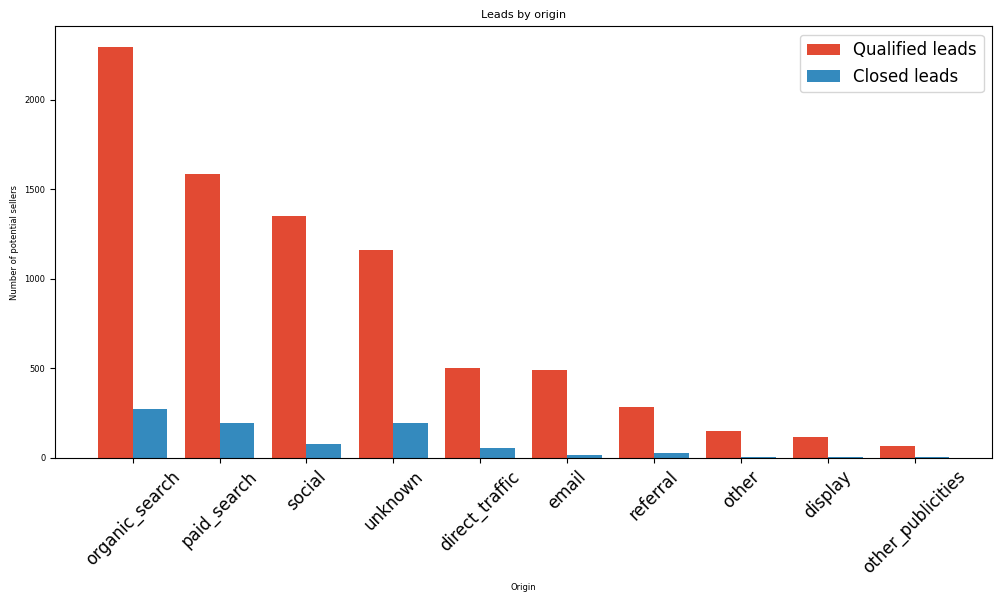

In [317]:
plt.figure(figsize=(10, 6))
bar_width = 0.4
r1 = range(len(df))
r2 = [x + bar_width for x in r1]

plt.bar(r1, df['qualified_leads'], color='#e24a33', width=bar_width, label='Qualified leads')
plt.bar(r2, df['closed_leads'], color='#348abe', width=bar_width, label='Closed leads')

plt.xlabel('Origin')
plt.ylabel('Number of potential sellers')
plt.title('Leads by origin')
plt.xticks([r + bar_width / 2 for r in range(len(df))], df['origin'],
           rotation=45, color='black', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

- 上图可知，只有一小部分合格的潜在客户最终成为 Olist 卖家
- 已关闭潜在客户的最大来源是“organicsearch”和“paidsearch”，其次是来源不明的潜在客户

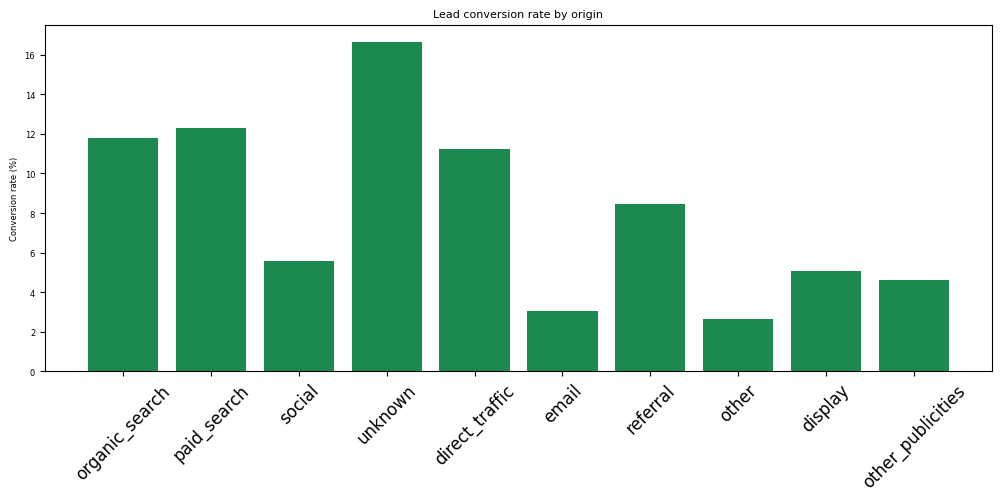

In [318]:
plt.figure(figsize=(10, 5))
plt.bar(df['origin'], df['conversion_rate'], color='#1c8a4f')
plt.ylabel('Conversion rate (%)')
plt.title('Lead conversion rate by origin')
plt.xticks(rotation=45, color='black', fontsize=12)
plt.tight_layout()
plt.show()

上文可知，虽然“paidsearch”、“organicsearch”和“directtraffic”的转化率最高，但“电子邮件”、“社交”、“展示广告”和“otherpublicities”等其他渠道的转化率较低

# 机器学习部分

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score

classification_report包含（precision、recall、f1-score、support)

In [320]:
import sqlite3
import pandas as pd

db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
conn = sqlite3.connect(db_path)

### ##  目标：用户复购率预测
- 核心：用过去的行为特征，预测未来的因变量
- 因为数据没有退款的任何信息，所以我们忽略它哈！
- 其次recency是日期不好做scaler的，我就把2018-06-30作为开始计算第一天去减了 算gap间隔
- 自变量是RFM+平均评论分
- 因变量是购买1次以上的

In [549]:
features = """
select
        a.order_id,
        b.customer_unique_id,
        a.order_purchase_timestamp as purchase_time,
        c.review_id,
        (julianday('2018-06-01') - julianday(max(date(a.order_purchase_timestamp)))) as recency_gapdays,
        count(a.order_id) as historical_frequency,
        sum(d.price) as monetary,
        avg(c.review_score) as avg_review_score,
        case when count(case when order_purchase_timestamp between '2017-06-01' and '2018-06-01' then order_id end) > 1 then 1 else 0
        end as repeat_flag 
    from orders a
        join customers b using (customer_id)
        join order_reviews c using (order_id)
        join order_items d using (order_id)
    where a.order_status = 'delivered'
        and date(a.order_purchase_timestamp) between '2017-06-01' and '2018-06-01'
    group by b.customer_unique_id 
"""

df = pd.read_sql(features, db_connection)
df.head(2)

,order_id,customer_unique_id,purchase_time,review_id,recency_gapdays,historical_frequency,monetary,avg_review_score,repeat_flag
0,e22acc9c116caa3f2b7121bbb380d08e,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,13359f48c3c7e41a2b8afca340937eeb,22.0,1,129.9,5.0,0
1,3594e05a005ac4d06a72673270ef9ec9,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,e383e10e36a765f04f752a37c1674e43,25.0,1,18.9,4.0,0


### 复购的显示 1，不复购的显示0

In [634]:
# 处理缺失值
df['avg_review_score'].fillna(df['avg_review_score'].median(), inplace=True)

# 剔除异常值（保留99%分位数内的数据）
df = df[df['monetary'] < df['monetary'].quantile(0.99)]

In [635]:
features=['recency_gapdays', 'historical_frequency', 'monetary', 'avg_review_score']
X = df[features]
y = df.iloc[:,-1]

In [636]:
print("X:", X.shape[0])
print("y:", y.shape[0])

X: 40805
y: 40805


In [637]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [638]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("过采样前训练集样本数量:", len(y_train))
print("过采样后训练集样本数量:", len(y_train_resampled))

过采样前训练集样本数量: 32644
过采样后训练集样本数量: 57356


In [639]:
import warnings
warnings.filterwarnings("ignore")

In [640]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) 

In [641]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

In [644]:
print("X_test样本数:", X_test_scaled.shape[0])  # 应与y_test一致
print("y_test样本数:", len(y_test))
print("y_pred样本数:", len(y_pred))

X_test样本数: 8161
y_test样本数: 40614
y_pred样本数: 18551


In [645]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(class_weight='balanced', max_iter=1000)
logr.fit(X_train_scaled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [646]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=5,
    random_state=42
)
rf.fit(X_train_scaled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [647]:
from xgboost import XGBClassifier

# 计算类别权重
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='auc',
    max_depth=3
)
xgb.fit(X_train_scaled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [648]:
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]    

y_pred_rf = logr.predict(X_test_scaled)
y_proba_rf = logr.predict_proba(X_test_scaled)[:, 1]    
# 7. 验证维度一致性
print("X_test样本数:", X_test_scaled.shape[0])  # 应与y_test一致
print("y_test样本数:", len(y_test))
print("y_pred样本数:", len(y_pred))

# 8. 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

X_test样本数: 8161
y_test样本数: 40614
y_pred样本数: 18551


ValueError: Found input variables with inconsistent numbers of samples: [40614, 18551]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]    

y_pred_rf = logr.predict(X_test)
y_proba_rf = logr.predict_proba(X_test)[:, 1]    

print(classification_report(y_test, y_pred))

In [559]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("标准差: {:.2f} %".format(accuracies.std()*100))

Accuracy: 99.97 %
标准差: 0.02 %


In [567]:
# 示例用户：最近购买30天前，历史购买3次，总消费200 BRL，平均评分4.5
new_user = pd.DataFrame([[200, 2, 150, 4.5]], columns=features)
new_user_scaled = scaler.transform(new_user)

# 使用XGBoost预测
repeat_prob = classifier.predict_proba(new_user_scaled)[:, 1][0]
repurchase_rate = np.sum(y_pred) / len(y_pred)
print(f"预测复购率: {repurchase_rate * 100:.2f}%")

预测复购率: 12.88%


In [628]:
import pandas as pd
import sqlite3
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 连接数据库
db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
conn = sqlite3.connect(db_path)

# SQL查询（严格隔离时间窗口）
query = """
SELECT
  customer_unique_id,
  -- 特征（基于历史数据，截止到2017-12-31）
  COUNT(order_id) AS historical_frequency,
  SUM(price) AS monetary,
  JULIANDAY('2017-12-31') - JULIANDAY(MAX(order_purchase_timestamp)) AS recency_gapdays,
  AVG(review_score) AS avg_review_score,
  -- 目标变量（预测未来30天复购：2018-01-01至2018-01-30）
  CASE WHEN count(order_id)> 1 THEN 1 ELSE 0 END AS repeat_flag
FROM orders
left JOIN customers USING (customer_id)
left JOIN order_items USING (order_id)
left JOIN order_reviews USING (order_id)
WHERE order_status = 'delivered'
  AND order_purchase_timestamp between '2017-01-01' and '2017-12-31'  
GROUP BY customer_unique_id;
"""

df = pd.read_sql(query, conn)
df.head(2)

,customer_unique_id,historical_frequency,monetary,recency_gapdays,avg_review_score,repeat_flag
0,0000f46a3911fa3c0805444483337064,1,69.00,295.121493,3.0,0
1,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,79.146053,4.0,0


In [629]:
# 处理缺失值
df['avg_review_score'].fillna(df['avg_review_score'].median(), inplace=True)

# 剔除异常值（保留99%分位数内的数据）
df = df[df['monetary'] < df['monetary'].quantile(0.99)]

# 定义特征和标签
features = ['recency_gapdays', 'historical_frequency', 'monetary', 'avg_review_score']
X = df[features]
y = df['repeat_flag']

In [630]:
# 按时间顺序排序（假设数据按时间递增排列）
df_sorted = df.sort_values('recency_gapdays', ascending=False)

# 划分训练集（前80%时间）和测试集（后20%时间）
train_size = int(len(df_sorted) * 0.8)
X_train_raw = df_sorted[features].iloc[:train_size]
y_train_raw = df_sorted['repeat_flag'].iloc[:train_size]
X_test = df_sorted[features].iloc[train_size:]
y_test = df_sorted['repeat_flag'].iloc[train_size:]

In [631]:
# 过采样（仅训练集）
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_raw)

# 标准化（基于训练集拟合Scaler）
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # 测试集使用相同Scaler

In [632]:
# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled==0])/len(y_train_resampled[y_train_resampled==1]))
}

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=3)
for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    for fold, (train_index, val_index) in enumerate(tscv.split(X_train_scaled)):
        # 划分训练集和验证集（按时间顺序）
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train, y_fold_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
        
        # 训练模型
        model.fit(X_fold_train, y_fold_train)
        
        # 验证集评估
        y_val_pred = model.predict(X_fold_val)
        print(f"Fold {fold + 1} - AUC: {roc_auc_score(y_fold_val, model.predict_proba(X_fold_val)[:, 1]):.3f}")
    
    # 最终测试集评估
    y_test_pred = model.predict(X_test_scaled)
    print("\n测试集性能:")
    print(classification_report(y_test, y_test_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]):.3f}")


=== Logistic Regression ===
Fold 1 - AUC: 1.000
Fold 2 - AUC: 1.000


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.